## Spell Decoder - Setup and Simulations


In [145]:
import numpy as np
import scipy
from sklearn import datasets
import matplotlib.pyplot as plt

## Assumptions (simplest case)
Let $C \in \mathbb N$ be the number of `channels` and $T \in \mathbb N$ be the number of sampled `time points` and $\mathcal S$ be the set of `spells`.

We assume that a single trial $X$ has the following properties:
- Weakly stationary stochastic process: $X = (X_t)_{t = 1, \ldots,  T}$ with $X_t \in \mathbb R^{C}$ and $\mathbb E[X_t | s] = a_s$ (regardless of $t$)
- Stable VAR(1) structure: $X_t|s = a_s + \mathbf A_s X_{t-1} + U_t$ with $\,\mathbb E[U_t] = 0, \; \mathbb E[U_tU_t^\top] = \boldsymbol \Sigma, \; \underset{k \neq t}{\forall} \; \mathbb E[U_tU_k^\top] = \mathbf 0$, and all eigenvalues of $A_s$ have modulus less than 1.

Then there exists a maximum likelihood estimator for $ B_s = (a_s, \mathbf A_s)$ with $\mathbf{Z = (Z_0, \ldots, Z_{T-1})}, \; \mathbf{Z_t = (1, X_t)^\top}$: $\hat B_s = \mathbf{XZ^\top(ZZ^\top)^{-1}}$.

### 0. The Data

In [99]:
nChan = 102 # number of magnetometer channels
nObs = 30 
nSamples = 15 * 200 # 15 seconds of data at 200 Hz
nSpells = 3

In [223]:
def plotMat(matrix: np.ndarray, title: str) -> None:
    fig, ax = plt.subplots()
    plt.imshow(matrix, cmap='viridis')
    plt.title(title)
    plt.colorbar()
    ax.xaxis.tick_top()

def genPDMat(n: int) -> np.ndarray:
    A = np.random.randint(10, size=(n, n))
    _, eigenvectors = np.linalg.eig(A)
    eigenvalues = np.random.uniform(low=-1., high=1., size=n)
    pdmat = eigenvectors @ np.diag(eigenvalues) @ np.linalg.inv(eigenvectors)
    return np.real(pdmat)

var = 1.
sigma = datasets.make_spd_matrix(nChan) + var * np.eye(nChan)
mu = np.random.randint(low=-10, high=10, size=nChan)
A = genPDMat(nChan)


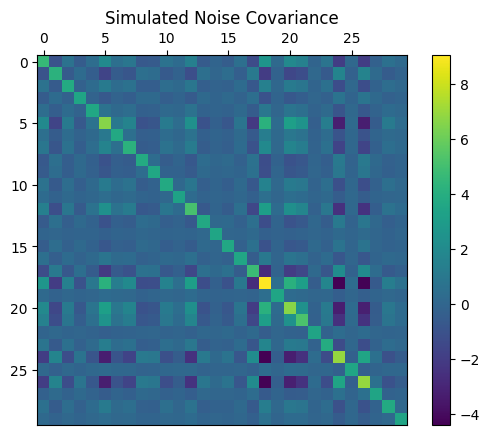

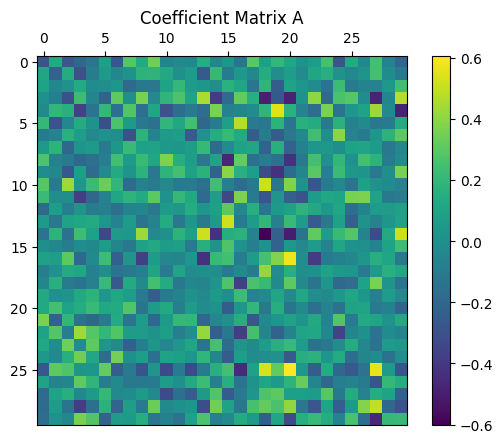

In [210]:
plotMat(sigma, "Simulated Noise Covariance")
plotMat(A, "Coefficient Matrix A")

In [224]:
x = np.zeros((nChan, nSamples)) + mu[:, np.newaxis]
noise = np.random.multivariate_normal(np.zeros(nChan), sigma, size=nSamples).T

x[:,0] += noise[:,0]
for t in range(1, nSamples):
    x[:,t] += A @ x[:,t-1] + noise[:,t] 

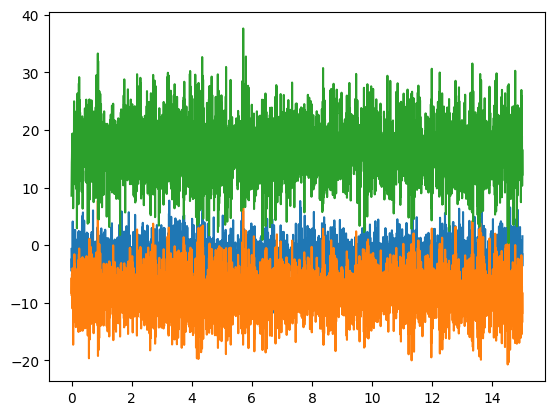

In [227]:
plt.plot(np.linspace(0, 15, nSamples), x[1,:])
plt.plot(np.linspace(0, 15, nSamples), x[2,:])
plt.plot(np.linspace(0, 15, nSamples), x[3,:])